In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.1.0
sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.2
pandas 1.0.3
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
#1.loads data
#.preprocess data->dataset
#3.tools
#3.1 generates position embedding
#3.2 create mask.(a.padding,b.decoder)
#3.3 scaled_dot_product_attention
#4.builds model
#4.1 MultiheadAttention
#4.2 EncoderLayer
#4.3 DecoderLayer
#4.4 EncoderModel
#4.5 DecoderModel
#4.6 Transformer
#5.optimizer &loss
#6.train step ->train
#7.Evaluate and Visualize


In [3]:
en_spa_file_path='./spa.txt'

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in  unicodedata.normalize('NFD',s) if unicodedata.category(c) !='Mn')


In [4]:
import re

def preprocess_sentence(s):
    s=unicode_to_ascii(s.lower().strip())
    
    #标点符号前后加空格
    s=re.sub(r"([?.!,])",r" \1 ",s)
    
    #多余的空格变成一个空格
    s=re.sub(r'[" "]+'," ",s)
    #去掉前后空格
    s=s.rstrip().strip()
    s='<start> '+s+ ' <end>'
    return s


            

In [5]:
def parse_data(filename):
    lines=open(filename,encoding='utf-8').read().strip().split('\n')
    sentence_pairs=[line.split('\t') for line in lines]
   
    preprocessed_sentence_pairs=[ 
        (preprocess_sentence(en),preprocess_sentence(sp) )for en,sp in sentence_pairs]
    
    return zip(*preprocessed_sentence_pairs)
    

In [6]:
en_dataset,sp_dataset=parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def tokenizer(lang):
    lang_tokenizer=keras.preprocessing.text.Tokenizer(
        num_words=None,filters='',split=' ')# num_words指定多少单词
    lang_tokenizer.fit_on_texts(lang)#根据词频生成词表
    tensor=lang_tokenizer.texts_to_sequences(lang)#生成句子id表示
    print(tensor[1])
    tensor=keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    print(tensor[2])
    return tensor,lang_tokenizer

input_tensor,input_tokenizer=tokenizer(sp_dataset[0:30000])
output_tensor,output_tokenizer=tokenizer(en_dataset[0:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input=max_length(input_tensor)
max_length_output=max_length(output_tensor)
print(max_length_input,max_length_output)

[1, 432, 3, 2]
[  1 709   3   2   0   0   0   0   0   0   0   0   0   0   0   0]
[1, 31, 3, 2]
[ 1 31  3  2  0  0  0  0  0  0  0]
16 11


In [8]:
from sklearn.model_selection import train_test_split
input_train ,input_eval,output_train,output_eval=train_test_split(input_tensor,output_tensor,test_size=0.2)
print(len(input_train),len(input_eval),len(output_train),len(output_eval))

24000 6000 24000 6000


In [9]:
def convert(example,tokenizer):
    for t in example:
        if t !=0:
            print("{}-->{}".format(t,tokenizer.index_word[t]))
            
convert(input_train[5],input_tokenizer)

1--><start>
8-->el
272-->mundo
6-->es
499-->pequeno
3-->.
2--><end>


In [10]:
def make_dataset(input_tensor,output_tensor,batch_size,epochs,shuffle):
    dataset=tf.data.Dataset.from_tensor_slices((input_tensor,output_tensor))
    if shuffle:
        dataset=dataset.shuffle(30000)
    dataset=dataset.repeat(epochs).batch(batch_size,drop_remainder=True)
    return dataset
    
batch_size=64
epochs=20
    
train_dataset=make_dataset(input_train,output_train,batch_size,epochs,True)
eval_dataset=make_dataset(input_eval,output_eval,batch_size,1,False)

In [11]:
for x,y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x,y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1 2746   10 ...    0    0    0]
 [   1    5 9896 ...    0    0    0]
 [   1   22  274 ...    0    0    0]
 ...
 [   1   32  903 ...    0    0    0]
 [   1    7   25 ...    0    0    0]
 [   1    7  231 ...    0    0    0]], shape=(64, 16), dtype=int32) tf.Tensor(
[[   1  291   10  840    3    2    0    0    0    0    0]
 [   1    5  315  666  125    3    2    0    0    0    0]
 [   1   25  243   28 2803    3    2    0    0    0    0]
 [   1   25    8 1576    3    2    0    0    0    0    0]
 [   1   13  430  452    3    2    0    0    0    0    0]
 [   1  342   47   46   54    3    2    0    0    0    0]
 [   1   63  272  322    3    2    0    0    0    0    0]
 [   1   33  332  132    3    2    0    0    0    0    0]
 [   1  278    7  230    6    2    0    0    0    0    0]
 [   1   35  138   21  437    6    2    0    0    0    0]
 [   1  277   57  130  703    3    2    0    0    0    0]
 [   1   18    7   23    9  449    6    2    0    0    0]
 [   1

In [12]:
#PE(pos,2i)=sin(pos/10000^(2i/d_modek))
#PE(pos,2i+1)=cos(pos/10000^(2i/d_modek))

#pos:[sententce_length,1]
#i.shape :[1,d_model]
#resule.shape:[sententce_length,d_model]
def get_angles(pos,i,d_model):#pos词语在句子中的位置，i是在embedding中的位置,d_model是embedding的大小
    angle_rates=1/np.power(10000,(2*(i//2))/np.float32(d_model))       
    return pos*angle_rates
def get_positional_embedding(sentence_length,d_model):
    angle_rads=get_angles(np.arange(sentence_length)[:,np.newaxis],
                         np.arange(d_model)[np.newaxis,:],d_model)#np.arange(sentence_length)[:,np.newaxis]绛sentence——length向量扩展成矩阵
    #sines.shape:[sentence_length,d_model/2]
    #cosine.shape:[sentence_length,d_model/2]
    sines=np.sin(angle_rads[:,0::2])
    cosines=np.cos(angle_rads[:,1::2])   
    #position_embedding.shape:[sentence_length,d_model]
    position_embedding=np.concatenate([sines,cosines],axis=-1)
    #position_embedding.shape:[1,sentence_length,d_model]
    position_embedding=position_embedding[np.newaxis,...]
    
    return tf.cast(position_embedding,dtype=tf.float32)#转化类型
position_embedding=get_positional_embedding(50,512)

print(position_embedding.shape)
    

(1, 50, 512)


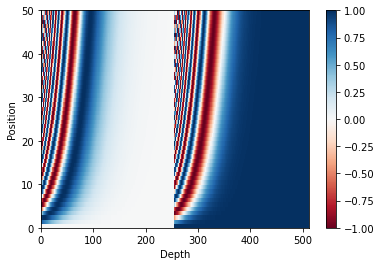

In [13]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0],cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0,512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)
    

In [14]:
#1.padding mask,2.look ahead(decoder只能和之前的词语发生关系，不能和之后的词语发生关系)

#batch_data.shape:[batch_size,seq_len]

def create_padding_mask(batch_data):
    
    padding_mask=tf.cast(tf.math.equal(batch_data,0),tf.float32)
    #[batch_size,1,1,seq_len]
    return padding_mask[:,tf.newaxis,tf.newaxis,:]

x=tf.constant([[4,45,3,0,0],[5,0,34,3,0],[89,0,3,0,1]])
create_padding_mask(x)
    
    

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 1., 1.]]],


       [[[0., 1., 0., 0., 1.]]],


       [[[0., 1., 0., 1., 0.]]]], dtype=float32)>

In [15]:
#attention_weights.shape:[3,3]
#[[1,0,0],1表示第一个单词与本身的关系，其余类推
#[4,4,0],
#[3,5,4]]
def create_look_ahead_mask(size):
    mask=1-tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [16]:
def scaled_dot_product_attention(q,k,v,mask):
    """
    Args:
        q:shape==(...,seq_len_q,depth)  q和k要做乘法，最后一个维度要相等
        k:shape==(...,seq_len_k,depth)
        v:shape==(...,seq_len_v,depth_v) 
        seq_len_k ==seq_len_v
        mask:shape==(...,seq_len_q,seq_len_k)
    """
    matmul_qk=tf.matmul(q,k,transpose_b=True)
    dk=tf.cast(tf.shape(k)[-1],tf.float32)#dk 是k最后一维的维度
    scaled_attention_logits=matmul_qk/tf.math.sqrt(dk)   
    if mask is not None:
        #使得在softmax后值趋近于0
        scaled_attention_logits+=(mask * -1e9)#为什么要用加法而不是乘法呢？logits以后做softmax时候，由于加上-le9，会让他的值无线接近于零
    #attention_weights.shape:(...,seq_len_q,seq_len_k)
    attention_weights=tf.nn.softmax(scaled_attention_logits,axis=-1)#在最后一个维度做softmax
    #output.shape:(...,seq_len_q,depth_v)
    output=tf.matmul(attention_weights,v)#矩阵乘法只作用于后两位，前面维度忽略掉
    return output,attention_weights
def print_scaled_dot_product_attention(q,k,v):
    temp_out,temp_att=scaled_dot_product_attention(q,k,v,None)
    print('temp_out',temp_out)
    print('``````')
    print('temp_att',temp_att)

In [17]:
temp_k=tf.constant([[10,0,0],
                   [0,10,0],
                   [0,0,10],
                   [0,0,10]],dtype=tf.float32)
temp_v=tf.constant([[1,0],
                   [10,0],
                   [100,5],
                   [1000,6]],dtype=tf.float32)
temp_q1=tf.constant([[0,10,0]],dtype=tf.float32)
np.set_printoptions(suppress=True)#改变显示结果
print_scaled_dot_product_attention(temp_q1,temp_k,temp_v)

temp_out tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
``````
temp_att tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)


In [18]:
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上：
    x->Wq0->q0
    x->Wk0->k0
    x->Wv0->v0   
    实战中：
    q->Wq0->q0
    k->Wk0->k0
    v->Wv0->v0
    实战中技巧;
    q->wq->Q->split->q0,q1,q2  
    """
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.d_model=d_model
        assert d_model % self.num_heads==0
        self.depth=d_model//self.num_heads
        self.WQ=keras.layers.Dense(self.d_model)
        self.WK=keras.layers.Dense(self.d_model)
        self.WV=keras.layers.Dense(self.d_model)
        self.dense=keras.layers.Dense(self.d_model)
    def split_heads(self,x,batch_size):
        #x.shape:(batch_size,seq_len,d_model)
        #d_mdoel=num_heads*depth
        #x->(batch_size,num_heads,seq_len,depth)
        x=tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))#d_model->num_heads,depth
        return tf.transpose(x,perm=[0,2,1,3])
    def call(self,q,k,v,mask):
        batch_size=tf.shape(q)[0]#???
        #
        q=self.WQ(q)#q.shape:(batch_size,seq_len_q,d_model)
        k=self.WK(k)#k.shape:(batch_size,seq_len_k,d_model)
        v=self.WV(v)#v.shape:(batch_size,seq_len_v,d_model)
        #q.shape:(batch_size,num_heads,seq_len_q,depth)
        q=self.split_heads(q,batch_size)
        k=self.split_heads(k,batch_size)
        v=self.split_heads(v,batch_size)
        
        #scaled_dot_product_attention.shape:(batch_size,num_heads,seq_len_q,depth)多头信息存在第二维和第4维上
        #attention_wights.shape:(batch_size,num_heads,seq_len_q,seq_len_k)
        scaled_attention_outputs,attention_weights=scaled_dot_product_attention(q,k,v,mask)
        #scaled_attention_outputs.shape:(batch_size,seq_len_q,num_heads,depth)
        scaled_attention_outputs=tf.transpose(scaled_attention_outputs,perm=[0,2,1,3])
        #concat_attention.shape:(batch_size,seq_len_q,d_model)
        concat_attention=tf.reshape(scaled_attention_outputs,(batch_size,-1,self.d_model))
        #output.shape:(batch_size,seq_len_q,d_model)
        output=self.dense(concat_attention)
        return output,attention_weights
        
temp_mpa=MultiHeadAttention(d_model=512,num_heads=8)
y=tf.random.uniform((1,60,256))#(batch_size,seq_len_q,dim)
output,attn=temp_mpa(y,y,y,mask=None)
print(output.shape)
print(attn.shape)


        

(1, 60, 512)
(1, 8, 60, 60)


In [19]:
def feed_forward_network(d_model,dff):
    return keras.Sequential([
        keras.layers.Dense(dff,activation='relu'),
        keras.layers.Dense(d_model)
    ])

In [20]:
class EncoderLayer(keras.layers.Layer):
    """
    x->self attention ->add &normalize&dropout\
    ->feed_forward->add&normalize &dropout
    """
    def __init__(self,d_model,num_heads,dff,rate=0.1):#rate,dropout
        super(EncoderLayer,self).__init__()
        self.mha=MultiHeadAttention(d_model,num_heads)
        self.ffn=feed_forward_network(d_model,dff)
        
        self.layer_norml=keras.layers.LayerNormalization(
                            epsilon=1e-6)
        self.layer_norml=keras.layers.LayerNormalization(
                            epsilon=1e-6)
        self.dropout1=keras.layers.Dropout(rate)
        self.dropout2=keras.layers.Dropout(rate)
    
    def call(self,x,training,encoder_padding_mask):
        #x.shape:(batch_size,seq_len,dim=d_model输出结果一样才可以做加法)
        #attn_output.shape:(batch_size,seq_len,d_model)
        #out1.shape:(batch_size,seq_len,d_model)
        attn_output,_=self.mha(x,x,x,encoder_padding_mask)
        attn_output=self.dropout1(attn_output,training=training)
        out1=self.layer_norml(x+attn_output)
        
        #ffn_output.shape:(batch_size,seq_len,d_model)
        #out2.shape:(batch_size,seq_len,d_model)
        ffn_output=self.ffn(out1)
        ffn_output=self.dropout2(attn_output,training=training)
        out2=self.layer_norml(out1+ffn_output)
        
        return out2
        
sample_encoder_layer=EncoderLayer(512,8,2048)
sample_input=tf.random.uniform((64,50,512))
sample_output=sample_encoder_layer(sample_input,False,None)
print(sample_output.shape) #经过encoder后x的shape没有变
    

(64, 50, 512)


In [21]:
class EncoderModel(keras.layers.Layer):
    def __init__(self,num_layers,input_vocab_size,max_length,d_model,num_heads,dff,rate=0.1):
        super(EncoderModel,self).__init__()
        self.d_model=d_model
        self.num_layers=num_layers
        self.max_length=max_length
        
        self.embedding=keras.layers.Embedding(input_vocab_size,self.d_model)
        #position_embedding.shape:(1,max_length,d_mdoel)
        self.position_embedding=get_positional_embedding(max_length,self.d_model)
        self.dropout=keras.layers.Dropout(rate)
        self.encoder_layers=[EncoderLayer(d_model,num_heads,dff,rate)
                             for _ in range(self.num_layers)]
        
    def call(self,x,training,encoder_padding_mask):
        #x.shape:(batch_size,input_seq_len)
        input_seq_len=tf.shape(x)[1]
        tf.debugging.assert_less_equal( input_seq_len,self.max_length," input_seq_len<=self.max_length")
        
        #x.shape:(batch_size,input_seq_len,d_model)
        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d_model,tf.float32))#缩放，使x的作用更大些
        x+=self.position_embedding[:,:input_seq_len,:]
        x=self.dropout(x,training=training)
        for i in range(self.num_layers):
            x=self.encoder_layers[i](x,training,encoder_padding_mask)
            
        return x   
        #x.shape:(batch_size,input_seq_len,d_modl)
        
sample_encoder_model=EncoderModel(2,8500,400,512,8,2048)

sample_encoder_model_input=tf.random.uniform((64,37))
sample_encoder_model_output=sample_encoder_model(sample_encoder_model_input,False,encoder_padding_mask=None)   
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [22]:
#定义模型把层当函数使用调用

In [23]:
class DecoderLayer(keras.layers.Layer):
    """
    x->self.attention->add&normalize&dropout->out1
    out1,encoding_outputs->attention->add&normalize&dropout->out2
    out2->ffn->add&normalize&dropout->out3
    
    """
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super(DecoderLayer,self).__init__()
        
        self.mha1=MultiHeadAttention(d_model,num_heads)
        self.mha2=MultiHeadAttention(d_model,num_heads)
        
        self.ffn=feed_forward_network(d_model,dff)
        
        self.layer_normal=keras.layers.LayerNormalization(
                            epsilon=1e-6)
        self.layer_norma2=keras.layers.LayerNormalization(
                            epsilon=1e-6)
        self.layer_norma3=keras.layers.LayerNormalization(
                            epsilon=1e-6)
        self.dropout1=keras.layers.Dropout(rate)
        self.dropout2=keras.layers.Dropout(rate)
        self.dropout3=keras.layers.Dropout(rate)
        
    def call(self,x,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask):
        #decoder_mask:由look_ahead_mask和decoder_padding_mask合并而来
        
        #x.shape:(batch_size,target_seq_len,d_model)
        #encoding_outputs.shape(batch_size,input_)
        
        #attn1,out1.shape:(batch_size,target_seq_len,d_model)
        attn1,attn_weights1=self.mha1(x,x,x,decoder_mask)
        attn1=self.dropout1(attn1,training=training)
        out1=self.layer_normal(attn1+x)
        
        attn2,attn_weights2=self.mha2(
        out1,encoding_outputs,encoding_outputs,encoder_decoder_padding_mask)
        
        attn2=self.dropout2(attn2,training=training)
        out2=self.layer_norma2(attn2+out1)
        
        ffn_output=self.ffn(out2)
        ffn_output=self.dropout3(ffn_output,training=training)
        out3=self.layer_norma3(ffn_output+out2)
        
        return out3,attn_weights1,attn_weights2
    
sample_decoder_layer=DecoderLayer(512,8,2048)
sample_decoder_input=tf.random.uniform((64,60,512))
sample_decode_output,sample_decoder_attn_weights1,sample_decoder_attn_weights2=sample_decoder_layer(sample_decoder_input,sample_output,False,None,None)


print(sample_decode_output.shape,sample_decoder_attn_weights1.shape,sample_decoder_attn_weights2.shape)
        
        

(64, 60, 512) (64, 8, 60, 60) (64, 8, 60, 50)


In [24]:
class DecoderModel(keras.layers.Layer):
        def __init__(self,num_layers,target_vocab_size,max_length,d_model,num_heads,dff,rate=0.1):
            super(DecoderModel,self).__init__()
            self.d_model=d_model
            self.num_layers=num_layers
            self.max_length=max_length

            self.embedding=keras.layers.Embedding(target_vocab_size,self.d_model)
            #position_embedding.shape:(1,max_length,d_mdoel)
            self.position_embedding=get_positional_embedding(max_length,self.d_model)
            self.dropout=keras.layers.Dropout(rate)
            self.decoder_layers=[DecoderLayer(d_model,num_heads,dff,rate)
                                 for _ in range(self.num_layers)]
        def call(self,x,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask):
            #x.shape:(batch_size,out_seq_len)
            output_seq_len=tf.shape(x)[1]
            tf.debugging.assert_less_equal(output_seq_len,self.max_length,"output_seq_len<=self.max_length") 
            
            attention_weights={}
            
            x=self.embedding(x)
            x*=tf.math.sqrt(tf.cast(self.d_model,tf.float32))
            x+=self.position_embedding[:,:output_seq_len,:]
            x=self.dropout(x,training=training)
            
            for i in range(self.num_layers):
                x,attn1,attn2=self.decoder_layers[i](x,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask)
                attention_weights['decoder{}_att1'.format(i+1)]=attn1
                attention_weights['decoder{}_att2'.format(i+1)]=attn2
                                  
            #x.shape:(batch_size,out_seq_len,d_,model)
            return x,attention_weights
                                  
sample_decoder_model  =DecoderModel(2,8000,1000,512,8,2048)                                
                                  
sample_decoder_model_input=tf.random.uniform((64,35))
sample_decoder_model_output,sample_decoder_model_att=sample_decoder_model(
                    sample_decoder_model_input,
                   sample_encoder_model_output,
training=False,decoder_mask=None,encoder_decoder_padding_mask=None)
                                  
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)#DecoderModel3层，所以attn有4个，35,35是self-attn，35,37是encoder-decoder atten

                                  

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [26]:
class Transformer(keras.Model):
    def __init__(self,num_layers,input_vocab_size,target_vocab_size,max_length,d_model,num_heads,dff,rate=0.1):
        super(Transformer,self).__init__()
        
        self.encoder_model=EncoderModel(num_layers,input_vocab_size,max_length
                                       ,d_model,num_heads,dff,rate)
        
        self.decoder_model=DecoderModel(num_layers,input_vocab_size,max_length
                                       ,d_model,num_heads,dff,rate)
        self.final_layer=keras.layers.Dense(target_vocab_size)
    def call(self,inp,tar,training,encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask):
        
        #encoding_outputs.shape:(batch_size,input-seq_len,d_model)
        encoding_outputs=self.encoder_model(inp,training,encoder_padding_mask)
        #decoding_outputs.shape:(batch_size,output_seq_len,target_vocab_
        decoding_outputs,attention_weights=self.decoder_model(
                    tar,encoding_outputs,training,decoder_mask,encoder_decoder_padding_mask)
        
        predictions=self.final_layer(decoding_outputs)
        return predictions,attention_weights
    
sample_transformer=Transformer(2,8500,8000,1000,512,8,2048,rate=0.1)

temp_input=tf.random.uniform((64,26))
temp_target =tf.random.uniform((64,31))
predictions,attention_weights=sample_transformer(temp_input,temp_target,
                   training=False,
                   encoder_padding_mask=None,
                   decoder_mask=None,encoder_decoder_padding_mask=None)

print(predictions.shape)
for key in attention_weights:
    print(key,attention_weights[key].shape)

    
        

(64, 31, 8000)
decoder1_att1 (64, 8, 31, 31)
decoder1_att2 (64, 8, 31, 26)
decoder2_att1 (64, 8, 31, 31)
decoder2_att2 (64, 8, 31, 26)


In [27]:
#1.initializes model
#2.define loss ,optimizer, learning_rate_schedule
#3.train_step
#4.train process

In [28]:
num_layers=4
d_model=128
dff=512
num_heads=8
input_vocab_size=pk_tokenizer.vocab_size+2#因为要加start和end
target_vocab_size=en_tokenizer.vocab_size+2
dropout_rate=0.1
transformer=Transformer(num_layers,
                       input_vocab_size,
                       target_vocab_size,
                       max_length,
                       d_model,num_heads,
                       dff,
                       dropout_rate)

NameError: name 'pk_tokenizer' is not defined

In [31]:
#lrate=(d_model**-0.5)*min(step_num**(-0.5),
#                  step_num*warm_up_steps**(-1.5) )

class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps=4000):
        super(CustomizedSchedule,self).__init__()
        self.d_model=tf.cast(d_model,tf.float32)
        self.warmup_steps=warmup_steps
    
    def __call__(self,step):
        arg1=tf.math.rsqrt(step)
        arg2=step*(self.warmup_steps**(-1.5))
        
        arg3=tf.math.rsqrt(self.d_model)
        
        return arg3*tf.math.minimum(arg1,arg2)
learning_rate=CustomizedSchedule(d_model)
optimizer=keras.optimizers.Adam(learning_rate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

Text(0.5, 0, 'Train step')

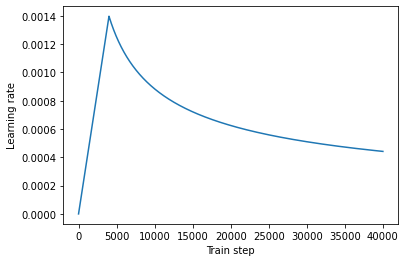

In [32]:
temp_learning_rate_schedule=CustomizedSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000,dtype=tf.float32)))
plt.ylabel("Learning rate")
plt.xlabel("Train step")


In [33]:
loss_object=keras.losses.SparseCategoricalCrossentropy(
                from_logits=True,reduction='none')#因为要对mask进行处理，不能用本身自带的reduction，所以要为none
def loss_function(real,pred):
    mask=tf.math.logical_not(tf.math.equal(real,0))#有padding的地方mask值都为零
    loss_=loss_object(real,pred)
    mask=tf.cast(mask,dtype=loss_.dtype)
    loss_*=mask
    return tf.reduce_mean(loss_)

In [37]:
def create_masks(inp,tar):
    """
    Encoder:
        -encoder_padding_mask 计算attention时候的(self attention of EncoderLayer)
    Decoder:
        -look_ahead_mask 前面单词不能看到后面的(self attention of DecoderLayer)
        -encoder_decoder_padding_mask  encoder_decoder之间的mask(encoder-decoder attention)
        -decoder_padding_mask decoder上的attention (self attention of DecoderLayer)
    """
    encoder_padding_mask=create_padding_mask(inp)
    encoder_decoder_padding_mask=create_padding_mask(inp)
    
    look_ahead_mask=create_look_ahead_mask(tf.shape(tar)[1])#被mask是1，不被mask是零
    decoder_padding_mask=create_padding_mask(tar)
    decoder_mask=tf.maximum(decoder_padding_mask,look_ahead_mask)
    print(encoder_padding_mask.shape)
    print(encoder_decoder_padding_mask.shape)
    print(look_ahead_mask.shape)#正方形矩阵，上三角是1，下三角是0
    print(decoder_padding_mask.shape)
    print(decoder_mask.shape)#tensor的自动补全机制，补上2个维度，把下一个维度复制39份
    return encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask
    

In [38]:
temp_inp,temp_tar=iter(train_dataset.take(1)).next()

In [41]:
train_loss=keras.metrics.Mean(name='train_loss')#定义累计的平均loss
train_accuracy=keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function
def train_step(inp,tar):
    tar_inp=tar[:,:-1]
    tar_rel=tar[:,1:]
    
    encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask=\
                                create_masks(inp,tar_inp)
        
    with tf.GradientTape() as tape:
        predictions,_=transformer(inp,tar_inp,True,encoder_padding_mask,
                                 decoder_mask,
                                 encoder_decoder_padding_mask)
        
        loss=loss_function(tar_real,predictions)
        
    gradients=tape.gradient(loss,transformer.trainable_variables)#计算梯度
    
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))#将梯度绑定到变量上
    train_loss(loss)
    train_accuracy(tar_real,preictions)#计算累计 的accuracy
    
    
epochs=20
for epoch in range(epochs):
    start=time.time()
    train_loss.reset_states()#从零开始累计
    train_accuracy.reset_states()
    for (batch,(inp,tar)) in enumerate(train_dataset):
        train_step(inp,tar)
        
        if batch%100==0:
            print('Epoch{} Batch{} Loss{:.4f} Accuracy{:.4f}'.format(epoch+1,batch,train_losss.result(),
                                                                    train_accuracy.result())
                         )
            
    
    
    print('Epoch{}Loss{:.4f} Accuracy {:.4f}'.format(
                    epoch+1,train_loss.result(),train_accuracy.result()))
    
    
    

(64, 1, 1, 16)
(64, 1, 1, 16)
(10, 10)
(64, 1, 1, 10)
(64, 1, 10, 10)


NameError: in converted code:

    <ipython-input-41-f2d4432f3ba5>:13 train_step  *
        predictions,_=transformer(inp,tar_inp,True,encoder_padding_mask,

    NameError: name 'transformer' is not defined


In [42]:
"""
eg:A B C D->E F G H.
train: A B C D,E F G->F G H
Eval:A B C D ->E
    A B C D E->F
    A B C D E F ->G
    A B C D E F G->H    transform训练时并行处理，预测时候不是
"""
def evaluate(inp_sentence):
    input_id_sentence=[pt_tokenizer.vacab_size]+pt_tokenizer.encode(inp_sentence)+[pt_tokenizer.vacab_size+1]#把文本的句子转化成id的句子
    #encoder_input.shape:(1,input_sentence_length)
    encoder_input=tf.expand_dims(input_id_sentence,0)
    #decoder_input.shape:(1,1)
    decoder_input=tf.expand_dims([en_tokenizer.vocab_size],0)
    #transform 与seqtoseq不一样：transform中decoder_input为多少，就会给出多少个预测值（多步预测）。seqtoseq天生是单步预测，每次只得到一个值。
    for i in range(max_length):
        encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask\
        =create_masks(encoder_input,decoder_input)
        #predictions.shape:(batch_size,output_target_len,target_vocab_size)
        predictions,attention_weights=transformer(encoder_input,decoder_input,False,
                                                  encoder_padding_mask,decoder_mask,encoder_decoder_padding_mask)
        
        #predictions.shape:(batch_size,target_vocab_size),中间维度只去一个值，维度消失
        predictions=predictions[:,-1,:]#只需要最后一个预测值，就是decoder_nput全部输入进去得到的值
        predicted_id=tf.cast(tf.argmax(predictions,axis=-1),tf.int32)
        
        if tf.equal(predicted_id,en_tokenizer.vocab_size+1):
            return tf.squeeze(decoder_input,axis=0),attention_weights
        
        decoder_input=tf.concat([decoder_input,predicted_id],axis=-1)
        
    return tf.squeeze(decoder_input,axis=0),attention_weights
        
        
        

In [ ]:
embedding_units=256
units=1024
input_vocab_size=len(input_tokenizer.word_index)+1#??
output_vocab_size=len(output_tokenizer.word_index)+1


In [24]:
class Encoder(keras.Model):
    def __init__(self,vocab_size,embedding_units,encoding_units,batch_size):
        super(Encoder,self).__init__()
        self.batch_size=batch_size
        self.encoding_units=encoding_units
        self.embedding=keras.layers.Embedding(vocab_size,embedding_units)
        self.gru=keras.layers.GRU(self.encoding_units,return_sequences=True,
                                 return_state=True,
                                 recurrent_initializer='glorot_uniform')    
    def call(self,x,hidden):
        x=self.embedding(x)
        output,state=self.gru(x,initial_state=hidden)
        return output,state #每一步的输出，以及最后一步输出的隐含状态      
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size,self.encoding_units))
    
encoder=Encoder(input_vocab_size,embedding_units,units,batch_size)
sample_hidden=encoder.initialize_hidden_state()
sample_output,sample_hidden=encoder(x,sample_hidden)
print(sample_output.shape)#输出的1024是状态是size
print(sample_hidden.shape)

InvalidArgumentError: Incompatible shapes: [3,1024] vs. [64,1024] [Op:AddV2] name: encoder/gru/add/

In [ ]:
class BahdanauAttention(keras.Model):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.w1=keras.layers.Dense(units)
        self.w2=keras.layers.Dense(units)
        self.v=keras.layers.Dense(1)
        
        
    def call(self,decoder_hidden,encoder_outputs):
        #decoder_hidden.shape:(batch_size,units)
        #encoder_outputs.shape:(batch_size,length,units)
        decoder_hidden_with_time_axis=tf.expand_dims(decoder_hidden,1)
        
        #before v:(batch_size,length,units)
        #after v:(batch_size,units)
        score=self.v(
            tf.nn.tanh(self.w1(encoder_outputs)+self.w2(decoder_hidden_with_time_axis)))
        #shape:(batch_size,length,1)
        attention_weights=tf.nn.softmax(score,axis=1)
        #context_vector.shape:(batch_size,length,units)在最后一个维度做扩展了
        context_vector=attention_weights*encoder_outputs
        #context_vector.shape(batch_size,units)在length上求和，length维度就没有了？？
        context_vector=tf.reduce_sum(context_vector,axis=1)
        
        return context_vector,attention_weights
    
attention_model=BahdanauAttention(units=10)
attention_results,attention_weights=attention_model(sample_hidden,sample_output)

print(attention_results.shape,attention_weights.shape)

In [ ]:
class Decoder(keras.Model):
    def __init__(self,vocab_size,embedding_units,decoding_units,batch_size):
        super(Decoder,self).__init__()
        self.batch_size=batch_size
        self.decoding_units=decoding_units
        self.embedding=keras.layers.Embedding(vocab_size,embedding_units)
        self.gru=keras.layers.GRU(self.decoding_units,
                                 return_sequences=True,
                                 return_state=True,
                                 recurrent_initializer='glorot_uniform')
        
        self.fc=keras.layers.Dense(vocab_size)
        self.attention=BahdanauAttention(self.decoding_units)
        
        
    def call(self,x,hidden,encoding_outputs):
        #context_vector.shape:(batch_size,units)
        context_vector,attention_weights=self.attention(hidden,encoding_outputs)
        #befor embedding:x.shape:(batch,1)decoding是单步的decoding
        #after embedding:x.shape:(batch_size,1,embedding_units)
        x=self.embedding(x)
        
        combined_x=tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)#在最后一个维度上拼接
        
        #output.shape:[batch_size,1,decoding_units]
        #state.shape:[batch_size,decoding_units]
        
        output,state=self.gru(combined_x)
        #output.shape:[batch_size,decoding_units]
        output=tf.reshape(output,(-1,output.shape[2]))
        
        #output.shape:[batch_size,vocab_size]
        output=self.fc(output)
        
        return output,state,attention_weights
        
        
decoder=Decoder(output_vocab_size,embedding_units,units,batch_size)

outputs=decode(tf.random.uniform((batch_size,1)),sample_hidden,sample_output)
decode_output,decoder_hidden,decoder_aw=outputs

print(decode_output.shape,decoder_hidden.shape,decoder_aw.shape)
        
    
        
        

In [ ]:

optimizer=keras.optimizers.Adam()

loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')# reduction表示损失函数该如何聚                                                     
        
def loss_function(real,pred):
    mask= tf.math.logical_not(tf.math.equal(real,0))# tf.math.equal(real,0) 是0的返回True，目标是让mask中不是零的变成1，其余为0          #mask输出的时候有很多padding，padding不应该计算在损失函数中去，把padding对应的损失函数对应的改为零
    loss_=loss_object(real,pred)
    mask=tf.cast(mask,dtype=loss_.dtype)#把mask布尔数据类型，转化成loss相同的
    
    loss_*=mask
    
    return tf.reduce_mean(loss_)# reduction='None'先不具合，乘完以后再聚合



In [ ]:
@tf.function
def train_step(inp,targ,encoding_hidden):
    loss=0
    with tf.GradientTape() as tape:
        encoding_outputs,encoding_hidden=encoder(inp,encoding_hidden)
        decoding_hidden=encoding_hidden
        for t in range(0,targ.shape[1]-1):
            decoding_input=tf.expand_dims(targ[:,t],1)
            predictions,decoding_hidden,_=decoder(decoding_input,decoding_hidden,
                                                 encoding_outputs)
            loss+=loss_function(targ[:,t+1],predictions)
            
    batch_loss=loss/int(targ.shape[0])
    variables=encoder.trainable_variables+decoder.trainable_variables
    gradients=tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))
    
    return batch_loss
    
        
        

In [ ]:
epochs=10#循环遍历10次数据集
steps_per_epoch=len(input_tensor)//batch_size#遍历数据集一次

for epoch in range(epochs):
    start=time.time()
    encoding_hidden=encoder.initialize_hidden_state()
    
    total_loss=0
    
    for (batch,(inp,targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss=train_step(inp,targ,encoding_hidden)
        total_loss+=batch_loss
        
        if batch%100==0:
            print('Epoch{} Batch {} Loss {:.4f}'.format(epoch+1,batch,batch_loss.numpy()))
        
    
    print('Epoch{} Batch {} Loss {:.4f}'.format(epoch+1,batch,batch_loss.numpy()))
    print('Time take for 1 epoch {} sec'.format(time.time()-start))



In [ ]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

reverse_word_index = dict(
    [(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

In [ ]:
def evaluate(input_sentence):
    attention_matrix=np.zeros((max_length_output,max_length_input))
    input_sentence=preprocess_sentence(input_sentence)
    inputs=[input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs=keras.preprocessing.sequence.pad_sequences(
        [inputs],maxlen=max_length_input,padding='post'
    )
    inputs=tf.convert_to_tensor(inputs)#保存成tensor
    
    results=''
#     encoding_hidden=encoder.initialize_hidden_state()
    encoding_hidden=tf.zeros((1,units))    
    encoding_outputs,encoding_hidden=encoder(inputs,encoding_hidden)
    decoding_hidden=encoding_hidden
    
    #eg:<start>->A
    #A->B->C->D
    #decoding_input.shape:(1,1)
    decoding_input=tf.expand_dims(output_tokenizer.word_index['<start>'],0)
    for t in range(max_length_output):
        pedictions,decoding_hidden,attention_weights=decoder(decoding_input,decoder_hidden,encoding_outputs)
        
        #attention_weights.shape:(batch_size,input_length,1)(1,16,1)
        attention_weights=tf.reshape(attention_weights,(-1,))#得到长度为16的向量？
        attention_matrix[t]=attention_matrix.numpy()
        
        #predictions.shape:(batch_size,vocab_size)(1,4935)
        predicted_id=tf.argmax(predictions[0].numpy())
        
        results+=output_tokenizer.index_word[predicted_id]+' '
        
        if output_tokenizer.index_word[predicted_id]=='<end>':
            return results,input_sentence,attention_matrix
            
        
        decoding_input=tf.expand_dims([predicted_id],0)
        
    return results,input_sentence,attention_matrix
 

def plot_attention(attention_matrix,input_sentence,predicted_sentence):
    fig=plt.figure(figsize=(10,10))
    ax=fig,add_subplot(1,1,1)
    ax.matshow(attention_matrix,cmap='viridis')
    font_dict={'fontsize':14}
    
    ax.set_xticklabels(['']+input_sentence,font_dict=font_dict,rotation=90)
    ax.set_yticklabels(['']+predicted_sentence,fontdict=font_dict)
    plt.show()
    
def translate(input_sentence):
    results,input_sentence,attention_matrix=evaluate(input_sentence)
    
    print(input_sentence)
    print(results)
    
    attention_matrix=attention_matrix[:len(results.split(" ")),:len(input_sentence.split(' '))]
    
    plot_attention(attention_matrix,input_sentence.split(' '),results.split(" "))
    
        

In [ ]:
translate(u'Te amo')

In [ ]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, # list of list
    value = word_index['<PAD>'],
    padding = 'post', # post, pre
    maxlen = max_length)

print(train_data[0])

In [ ]:
embedding_dim = 16
batch_size = 512

single_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.LSTM(units = 64, return_sequences = False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer = 'adam',
                         loss = 'binary_crossentropy',
                         metrics = ['accuracy'])


In [ ]:
history_single_rnn = single_rnn_model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


In [ ]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_rnn, 'accuracy', 30, 0, 1)
plot_learning_curves(history_single_rnn, 'loss', 30, 0, 1)

In [ ]:
single_rnn_model.evaluate(
    test_data, test_labels,
    batch_size = batch_size,)

In [ ]:
embedding_dim = 16
batch_size = 512

model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 64, return_sequences = True)),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 64, return_sequences = False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_data, train_labels,
    epochs = 30,
    batch_size = batch_size,
    validation_split = 0.2)


In [ ]:
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

In [ ]:
embedding_dim = 16
batch_size = 512

bi_rnn_model = keras.models.Sequential([
    # 1. define matrix: [vocab_size, embedding_dim]
    # 2. [1,2,3,4..], max_length * embedding_dim
    # 3. batch_size * max_length * embedding_dim
    keras.layers.Embedding(vocab_size, embedding_dim,
                           input_length = max_length),
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units = 32, return_sequences = False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

bi_rnn_model.summary()
bi_rnn_model.compile(optimizer = 'adam',
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

In [ ]:
history = bi_rnn_model.fit(
    train_data, train_labels,
    epochs = 5,
    batch_size = batch_size,
    validation_split = 0.2)

In [ ]:
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

In [ ]:
bi_rnn_model.evaluate(test_data, test_labels, batch_size = batch_size)